# A Guide to the Generation Package

In this notebook I present the routing instance generation package I developed as part of my thesis. 

## Contents in this notebook:
1. [Notebook setup](#setup)
2. [Network design](#design)
    1. [Area, Depot, Customers](#tsp)
    2. [Demands, Vehicles, Capacities](#cvrp)
    3. [Time windows, Service times](#cvrptw)
3. [Data generation](#datageneration)
    1. [Instance generation examples](#examples)
    2. [Data set generation](#dataset)

## 1. Notebook setup <a name="setup"></a>

In [1]:
# Install required packages.
# !pip install requirements.txt

# Change directory to main project folder.
import os
print(f'This folder: {os.getcwd()}')
os.chdir("..")
print(f'Project folder: {os.getcwd()}\n')

# Import packages.
import generation
import routing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# help(generation)
?generation

This folder: C:\Users\muell\thesis_main\thesis_code\notebooks - GitHub
Project folder: C:\Users\muell\thesis_main\thesis_code



Type:        module
String form: <module 'generation' from 'C:\\Users\\muell\\thesis_main\\thesis_code\\generation\\__init__.py'>
File:        c:\users\muell\thesis_main\thesis_code\generation\__init__.py
Docstring:  
A package to generate routing instances.

Author: Jens Mueller
Python Version: 3.9.7

MODULES:

    generate_instance.py - Generate a single routing instance (variants include TSP, CVRP, and CVRPTW).
    generate_dataset.py  - Generate a full dataset of routing instances.
    area.py              - Generate a service area of varying size and shape.
    locations.py         - Generate a set of locations following one of several possible distributions.
    demands.py           - Generate a set of demands following one of several possible distributions.
    time_windows.py      - Generate a set of time windows following one of several possible distributions.
    service_times.py     - Generate a set of service times following one of several possible distributions.
    featur

## 2. Network design <a name="design"></a>

In this section I explain my design choices in the network generation procedure. To have a model that is able to generalize to several different types of instances, the training data needs to consist of a broad range of distributions in all parameters (and the sample needs to be sufficiently large). Both are not given in the current benchmarks, but I try to incorporate them in my methodology.

Here I show the individual aspects. The complete function can be found at generation/generate_instance.py

### 2.1. Area, Depot, Customers, Locations <a name="tsp"></a>

#### Service area

Service area characteristics:
service_area = 560414.7571
side_ratio = 1.4177
lx = (628.7279, 2), ly = 891.347

Share of samples with side ratio in range 1.0-1.5: 89.19 %


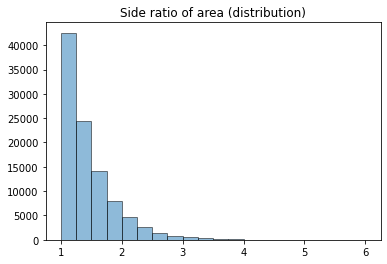

In [2]:
# Generate service area and print parameters
area, side_ratio, lx, ly = generation.generate_area(
    min_size=10_000, 
    max_size=1_000_000, 
    min_ratio=1, 
    max_ratio=5)
print(f'Service area characteristics:')
print(f'service_area = {area}') # sampled uniformly between 10,000 and 1,000,000.
print(f'side_ratio = {side_ratio}')
print(f'lx = {lx, 2}, ly = {ly}')

# Analyze the side ratio distribution (exponential)
samples = 100_000
side_ratios = np.array([generation.generate_area()[1] for i in range(samples)])
print('\nShare of samples with side ratio in range 1.0-1.5:', 
      round(100 * side_ratios[np.where(side_ratios<2)].shape[0] / samples, 4),'%')
plt.hist(side_ratios, bins=20, range=(1,6), alpha=0.5, histtype='bar', ec='black')
plt.title('Side ratio of area (distribution)')
plt.show()

#### Number of customers

In [3]:
# The number of customers is sampled uniformly between 20 and 100 (common range in literature).
num_customers = np.random.randint(low=20, high=100)
print(f'num_customers = {num_customers}')
#num_customers = 500

num_customers = 49


#### Locations

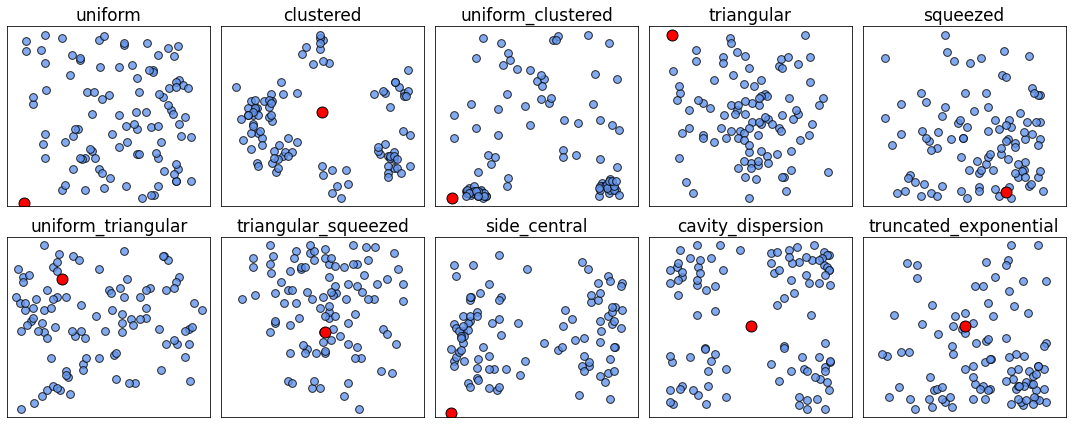

In [4]:
%matplotlib inline

# Show possible location distributions

fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

location_distributions = [
    'uniform', 'clustered', 'uniform_clustered', 'triangular', 'squeezed', 'uniform_triangular',
    'triangular_squeezed', 'side_central', 'cavity_dispersion', 'truncated_exponential'] 
for i in range(10):
    loc_distr = location_distributions[i]
    locations, depot_pos, loc_distr = generation.generate_locations(
        num_locations=100, depot_pos=None, loc_distr=loc_distr, lx=100, ly=100)
    axs[i].tick_params(axis='both', which='both', bottom=False, top=False, right=False, left=False, labelbottom=False)
    axs[i].set_autoscale_on(False)
    axs[i].set_xlim((0,100))
    axs[i].set_ylim((0,100))
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].axis('equal')
    axs[i].scatter(locations[1:,0], locations[1:,1], c='cornflowerblue', s=60, alpha=0.8, ec='black')
    axs[i].scatter(locations[0,0], locations[0,1], c='red', s=120, alpha=1.0, ec='black')
    axs[i].set_title(loc_distr, fontsize=17)
    
plt.autoscale(enable=False, axis='both', tight=None)
fig.tight_layout()
#plt.savefig('loc_distributions.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
#plt.savefig('loc_distributions.jpg', pad_inches=0.4)#bbox_inches='tight')
plt.show()

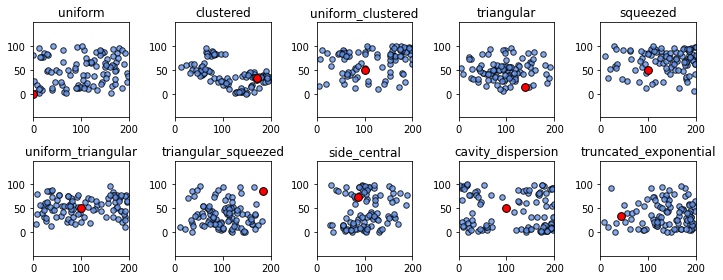

In [5]:
# Show again with larger side_ratio

fig, axs = plt.subplots(2,5, figsize=(10, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

location_distributions = [
    'uniform', 'clustered', 'uniform_clustered', 'triangular', 'squeezed', 'uniform_triangular',
    'triangular_squeezed', 'side_central', 'cavity_dispersion', 'truncated_exponential'] 
for i in range(10):
    loc_distr = location_distributions[i]
    locations, depot_pos, loc_distr = generation.generate_locations(
        num_locations=100, depot_pos=None, loc_distr=loc_distr, lx=200, ly=100)
    axs[i].axis('equal')
    axs[i].set_xlim((0,200))
    axs[i].set_ylim((0,100))
    axs[i].scatter(locations[1:,0], locations[1:,1], c='cornflowerblue', s=30, alpha=0.8, ec='black')
    axs[i].scatter(locations[0,0], locations[0,1], c='red', s=60, alpha=1.0, ec='black')
    axs[i].set_title(loc_distr)
    
fig.tight_layout()
plt.show()

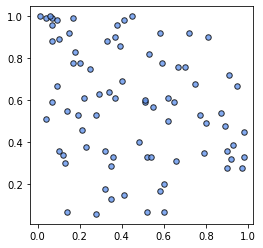

In [9]:
# Illustrate the rotate function

num_customers=80
locations = generation.generate_locations(num_customers, depot_pos='loc_distr', loc_distr='truncated_exponential', lx=1, ly=1)[0]

# the function above already includes rotation, just for illustration here again
def rotate(locations, num_rotations):
    """Rotates the locations in a the area (since some distribution focus on one side/corner)."""
    for i in range(num_rotations):
        x = locations[:,0].copy()
        y = locations[:,1].copy()
        locations[:,0] = y
        locations[:,1] = -1*x+1
    return locations
locations = rotate(locations, np.random.randint(4))

fig = plt.figure(figsize=(4,4))
plt.scatter(locations[:,0], locations[:,1], c='cornflowerblue', s=30, alpha=0.8, ec='black')
plt.axis('equal')
plt.show()

depot_pos: uniform
loc_distr: truncated_exponential
locations: <class 'numpy.ndarray'> (81, 2)


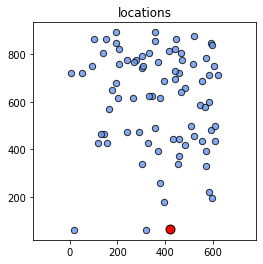

In [10]:
# Generate locations for a specific example
locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=num_customers+1, 
    depot_pos=None, # all options in generation/locations.py
    loc_distr=None, # all options in generation/locations.py
    lx=lx, 
    ly=ly)
print('depot_pos:', depot_pos)
print('loc_distr:', loc_distr)  
print('locations:', type(locations), locations.shape)

# Plot locations
fig = plt.figure(figsize=(4,4))
plt.axis('equal')
#plt.scatter(locations[:,0], locations[:,1], c='blue', s=40, alpha=1, ec=None)
plt.scatter(locations[1:,0], locations[1:,1], c='cornflowerblue', s=40, alpha=0.8, ec='black')
plt.scatter(locations[0,0], locations[0,1], c='red', s=80, alpha=1.0, ec='black')
plt.title('locations')
plt.show()

#### Distances

In [11]:
### Compute distance matrix (Euclidean distances)
distance_matrix = routing.compute_distance_matrix(locations)
print('distance_matrix:', type(distance_matrix), distance_matrix.shape)

distance_matrix: <class 'numpy.ndarray'> (81, 81)


### 2.2. Demands, Vehicles, Capacities <a name="cvrp"></a>

#### Demands

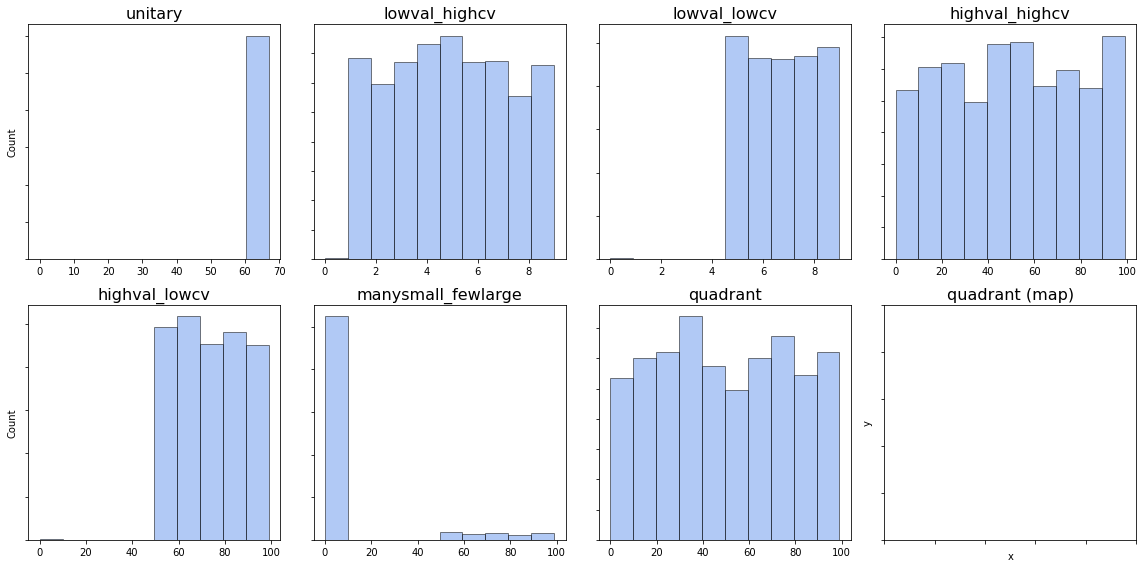

In [14]:
# Show possible demand distributions

num_customers=1200
lx, ly = 10000, 10000
locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=num_customers+1, lx=lx, ly=ly)

# plot
fig, axs = plt.subplots(2,4, figsize=(16, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

demand_distributions = ['unitary', 'lowval_highcv', 'lowval_lowcv', 'highval_highcv', 
                          'highval_lowcv', 'manysmall_fewlarge', 'quadrant']
for i in range(7):
    dem_distr = demand_distributions[i]
    demands, dem_distr = generation.generate_demands(
        num_customers=num_customers, dem_distr=dem_distr, locations=locations, lx=lx, ly=ly)
    #axs[i].set_xlim((0,100))
    axs[i].hist(demands, alpha=0.5, color='cornflowerblue', ec='black', linewidth=1)
    axs[i].set_title(dem_distr, fontdict={'fontsize': 16, 'fontweight': 'medium'})
    axs[i].set_yticklabels([])

axs[7].set_title('quadrant (map)', fontdict={'fontsize': 16, 'fontweight': 'medium'})    
axs[7].set_xticklabels([])
axs[7].set_yticklabels([])
axs[7].set(xlabel='x', ylabel='y')

axs[0].set(ylabel='Count')
axs[4].set(ylabel='Count')

fig.tight_layout()
#plt.savefig('demsnew.jpg', pad_inches=0.4, dpi=400)#bbox_inches='tight')
plt.show()

{'area': 358594.5601, 'side_ratio': 1.0551, 'lx': 582.9833, 'ly': 615.1027, 'num_customers': 100, 'depot_pos': 'central', 'loc_distr': 'cavity_dispersion', 'dem_distr': 'quadrant', 'cap_ratio': 0.2, 'avg_route_size': 20.0, 'possible_rounds': 1.7783, 'st_distr': 'unitary', 'tw_share': 0, 'tw_center_distr': 'uniform', 'tw_width_distr': 'medium'} 

Solution distance: 6036.01 (vehicles used: 6)



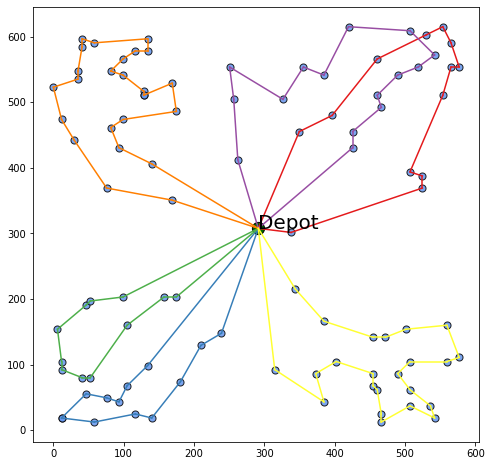

In [6]:
# plot quadrant for thesis
instance = generation.generate_instance(variant='cvrptw', loc_distr='cavity_dispersion', depot_pos='central', num_customers = 100, dem_distr='quadrant', cap_ratio=0.2, tw_share=0, st_distr='unitary')
print(instance.gen_params,'\n')
instance.solve(first_solution='PATH_CHEAPEST_ARC',
               local_search='GUIDED_LOCAL_SEARCH', 
               time_limit=5, verbose=1)
instance.plot(solved=True, fig_size=(8,8), details=None, font_size=10)

dem_distr: lowval_highcv
demands: [0 9 4 ... 3 1 3]
dem_avg 5.0717


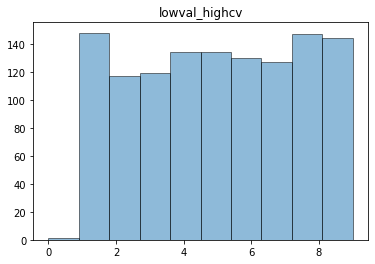

In [15]:
# Generate demands for a specific example
demands, dem_distr = generation.generate_demands(
    num_customers=num_customers, 
    dem_distr=None, # 'manysmall_fewlarge' # all options in generation/demands.py
    locations=locations, lx=lx, ly=ly
)  
print('dem_distr:', dem_distr)
print('demands:',demands)
dem_avg = np.sum(demands) / num_customers
print('dem_avg', round(dem_avg, 4))

# Plot demands
plt.hist(demands, alpha=0.5, histtype='bar', ec='black')
plt.title(dem_distr)
plt.show()

#### Vehicle capacities

In [16]:
# What percentage of customers can be covered by one vehicle on average
cap_ratio = round(np.random.default_rng().uniform(0.02, 0.8), 4)
print(f'cap_ratio = {round(cap_ratio, 2)}')

# How many customers can a vehicle serve on average
avg_route_size = round(max(
    np.max(demands) / dem_avg, # lower bound (s.t. cap_avg>=dem_max) since cust. can only receive 1 vehicle.
    cap_ratio*num_customers), 4)
print(f'avg_route_size = {round(avg_route_size, 2)}')

# What is the average vehicle capacity (homogenous fleet)
cap_avg = np.ceil(avg_route_size * dem_avg)
print(f'cap_avg = {cap_avg}')

# Number of vehciles (is assumed to be free to ensure feasibility. The solver reduces this.)
num_vehicles = num_customers

# Vehicle capacities
vehicle_capacities = np.ones(num_vehicles) * cap_avg
print('capacities:', vehicle_capacities.astype(int))

cap_ratio = 0.61
avg_route_size = 729.36
cap_avg = 3700.0
capacities: [3700 3700 3700 ... 3700 3700 3700]


### 2.3. Time windows, Service times <a name="cvrptw"></a>

#### Time horizon

In [17]:
# Possible rounds around the area during the depot time window
possible_rounds = round(np.random.default_rng().triangular(2*np.sqrt(2)/4, 2, 8), 4)
print('possible_rounds', possible_rounds)

# Time horizon (depot time window)
tw_width_depot = np.around(possible_rounds, 4) * (2*lx + 2*ly)
print('time_horizon', round(tw_width_depot, 4))

possible_rounds 5.0882
time_horizon 203528.0


#### Service times

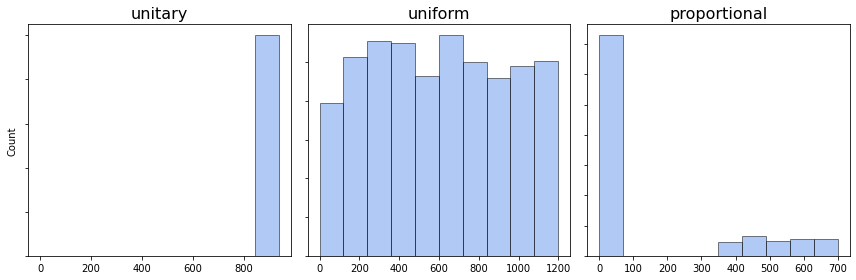

In [18]:
# Show possible service times distributions

num_customers=1000
lx, ly = 1000, 1000
locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=num_customers+1, lx=lx, ly=ly)
demands, dem_distr = generation.generate_demands(
    num_customers, dem_distr='manysmall_fewlarge', locations=locations, lx=lx, ly=ly)  
possible_rounds = 3
tw_width_depot = np.around(possible_rounds, 4) * (2*lx + 2*ly)

# plot
fig, axs = plt.subplots(1,3, figsize=(12, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

st_distributions = ['unitary', 'uniform', 'proportional']

for i in range(3):
    st_distr = st_distributions[i]
    service_times, st_distr = generation.generate_service_times(
        num_customers=num_customers, st_distr=st_distr, tw_width_depot=tw_width_depot, demands=demands)
    #axs[i].set_xlim((0,100))
    axs[i].hist(service_times, alpha=0.5, color='cornflowerblue', ec='black', linewidth=1)
    axs[i].set_title(st_distr, fontdict={'fontsize': 16, 'fontweight': 'medium'})
    axs[i].set_yticklabels([])
axs[0].set(ylabel='Count')
fig.tight_layout()
#plt.savefig('stsnew.jpg', pad_inches=0.4, dpi=300)#bbox_inches='tight')
#plt.savefig('stsnew.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
plt.show()

st_distr proportional
service_times: <class 'numpy.ndarray'> (1001,)
[ 0 63 39 ... 31 63 47]


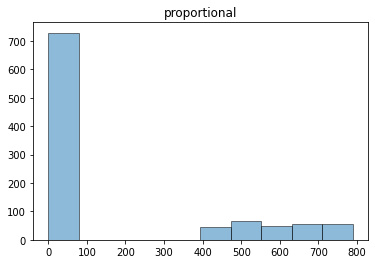

In [20]:
# Generate service times for a specific example
service_times, st_distr = generation.generate_service_times(
    num_customers=num_customers, 
    st_distr=None, # 'proportional' # see all options at generation/sample_service_times.py
    tw_width_depot=tw_width_depot, 
    demands=demands)
print('st_distr', st_distr)
print('service_times:', type(service_times), service_times.shape)
print(service_times)
# print('demands', demands)
# print('service_times', service_times)

# Plot service times
plt.title(st_distr)
plt.hist(service_times, alpha=0.5, histtype='bar', ec='black')
plt.show()

#### Time windows

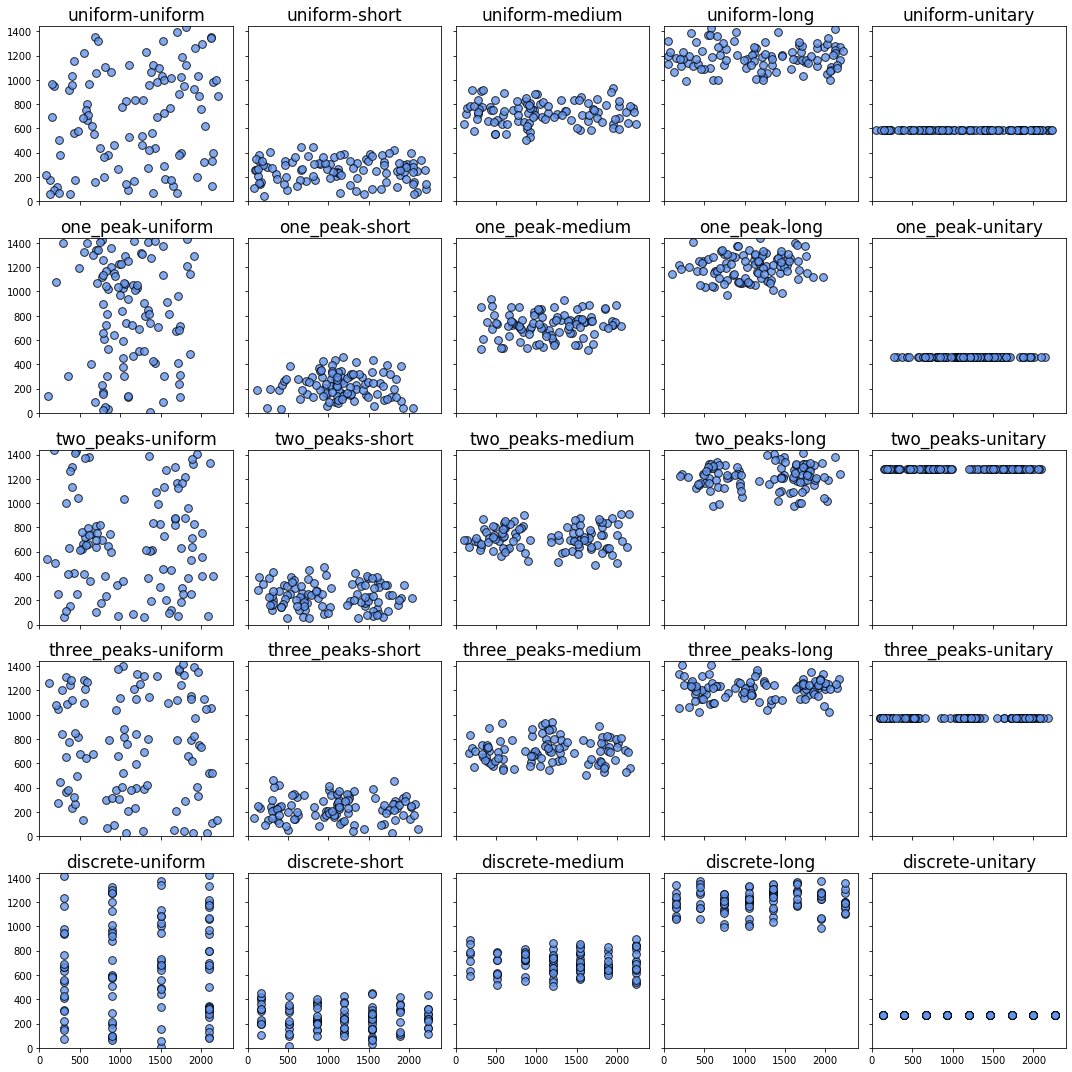

In [21]:
# Show possible time windows distributions (center and width)

num_customers=100
tw_width_depot=2400
tw_depot = np.array([0, tw_width_depot])
tw_share=1
depot_dist=np.ones(1000) * 50
service_times=np.ones(1000) * 0.05*2400

fig, axs = plt.subplots(5,5, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

count = 0

for i in range(5):
    tw_center_distr = ['uniform','one_peak', 'two_peaks', 'three_peaks', 'discrete']   
    center = tw_center_distr[i]
    
    for j in range(5):
        tw_width_distr = ['uniform','short', 'medium', 'long', 'unitary'] 
        width = tw_width_distr[j]
        
        time_windows, tw_center_distr, tw_width_distr = generation.generate_time_windows(
            num_customers=num_customers, 
            tw_center_distr=center, 
            tw_width_distr=width, 
            tw_width_depot=tw_width_depot,
            tw_share=tw_share,
            depot_dist=depot_dist,
            service_times=service_times)

        tw_centers = (time_windows[:,0]+time_windows[:,1])/2
        tw_widths = time_windows[:,1]-time_windows[:,0]
        tw_starts = time_windows[:,0][tw_widths<tw_width_depot]
        tw_ends = time_windows[:,1][tw_widths<tw_width_depot]
        
        #axs[count].axis('equal')
        axs[count].set_xlim((0,2400))
        axs[count].set_ylim((0,1440))
        axs[count].scatter(tw_centers[tw_widths<tw_width_depot], tw_widths[tw_widths<tw_width_depot], s=60, c='cornflowerblue', alpha=0.8, ec='k')
        axs[count].set_title(f'{center}-{width}', fontsize=17)
        
        
        count+=1

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass

fig.tight_layout()
#plt.savefig('tw_distributions.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
#plt.savefig('tw_distributions.jpg', pad_inches=0.4)#bbox_inches='tight')
plt.show()

tw_share 0.78 -> 78 customers with time window
tw_center_distr: one_peak
tw_width_distr: medium
time_windows: <class 'numpy.ndarray'> (101, 2)


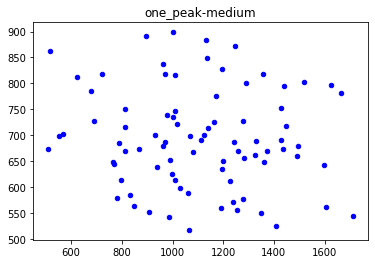

In [22]:
# Generate service times for a specific example

num_customers=100
lx, ly = 1000, 1000
locations, depot_pos, loc_distr = generation.generate_locations(
    num_locations=num_customers+1, lx=lx, ly=ly)
distance_matrix = routing.compute_distance_matrix(locations)

# Share of customers with time_windows
tw_share = np.random.default_rng().triangular(0.25, 1, 1)
print('tw_share', round(tw_share, 2), '->', int(tw_share * (num_customers)), 'customers with time window')

# Generate time windows
time_windows, tw_center_distr, tw_width_distr = generation.generate_time_windows(
    num_customers=num_customers, 
    tw_center_distr=None, 
    tw_width_distr=None, 
    tw_width_depot=tw_width_depot,
    tw_share=tw_share,
    depot_dist=distance_matrix[0][1:],
    service_times=service_times[1:])
print('tw_center_distr:', tw_center_distr)
print('tw_width_distr:', tw_width_distr)
print('time_windows:', type(time_windows), time_windows.shape)

# Plot time windows
tw_centers = (time_windows[:,0]+time_windows[:,1])/2
tw_widths = np.around(time_windows[:,1]-time_windows[:,0], 2)
plt.title(f'{tw_center_distr}-{tw_width_distr}')
plt.set_xlim=((0, tw_width_depot))
plt.set_ylim=((0, tw_width_depot*0.6))
plt.scatter(tw_centers[tw_widths<tw_widths[0]], tw_widths[tw_widths<tw_widths[0]], s=20, c='blue')
plt.show()

## 3. Data generation <a name="datageneration"></a>

### 3.1. Instance generation examples <a name="examples"></a>

In [24]:
# Simple example
instance = generation.generate_instance()
instance.gen_params
#instance.__dict__

{'area': 398113.6166,
 'side_ratio': 1.0376,
 'lx': 642.7119,
 'ly': 619.4278,
 'num_customers': 72,
 'depot_pos': 'loc_distr',
 'loc_distr': 'uniform',
 'dem_distr': 'highval_lowcv',
 'cap_ratio': 0.6747,
 'avg_route_size': 48.5784,
 'possible_rounds': 3.567,
 'st_distr': 'proportional',
 'tw_share': 0.5789,
 'tw_center_distr': 'two_peaks',
 'tw_width_distr': 'long'}

#### TSP

{'area': 260554.5476, 'side_ratio': 1.6726, 'lx': 660.1535, 'ly': 394.6878, 'num_customers': 60, 'depot_pos': 'central', 'loc_distr': 'triangular_squeezed'} 

Solution distance: 2606.01 (vehicles used: 1)

Route:
 0 -> 40 -> 28 -> 57 -> 14 -> 42 -> 6 -> 50 -> 22 -> 46 -> 9 -> 44 -> 31 -> 2 -> 39 -> 3 -> 38 -> 48 -> 18 -> 1 -> 34 -> 54 -> 52 -> 47 -> 41 -> 53 -> 43 -> 10 -> 51 -> 8 -> 60 -> 19 -> 58 -> 25 -> 13 -> 56 -> 24 -> 45 -> 7 -> 32 -> 21 -> 29 -> 16 -> 36 -> 30 -> 49 -> 12 -> 37 -> 20 -> 17 -> 23 -> 15 -> 26 -> 27 -> 55 -> 11 -> 59 -> 35 -> 4 -> 5 -> 33 -> 0



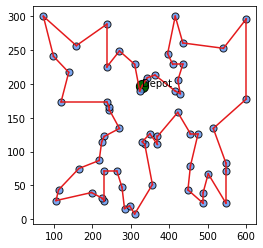

In [25]:
# TSP
instance = generation.generate_instance(variant='tsp')
print(instance.gen_params,'\n')
instance.solve(first_solution='PATH_CHEAPEST_ARC',
               local_search='GUIDED_LOCAL_SEARCH', 
               time_limit=5, verbose=2)
instance.plot(solved=True)

#### CVRP

{'area': 338442.4406, 'side_ratio': 1.1166, 'lx': 550.544, 'ly': 614.7419, 'num_customers': 60, 'depot_pos': 'central', 'loc_distr': 'cavity_dispersion', 'dem_distr': 'quadrant', 'cap_ratio': 0.2232, 'avg_route_size': 13.392} 

Solution distance: 4921.49 (vehicles used: 5)

Route for vehicle 0 (distance: 784.64, load: 530):
 0 Load(0) ->  45 Load(66) ->  15 Load(144) ->  7 Load(218) ->  29 Load(284) ->  47 Load(378) ->  3 Load(431) ->  17 Load(530) ->  0 Load(530)

Route for vehicle 1 (distance: 841.87, load: 576):
 0 Load(0) ->  43 Load(75) ->  38 Load(168) ->  39 Load(240) ->  20 Load(314) ->  37 Load(376) ->  31 Load(440) ->  19 Load(519) ->  53 Load(576) ->  0 Load(576)

Route for vehicle 3 (distance: 1129.31, load: 457):
 0 Load(0) ->  24 Load(40) ->  55 Load(83) ->  4 Load(85) ->  57 Load(126) ->  22 Load(137) ->  42 Load(158) ->  23 Load(198) ->  52 Load(222) ->  44 Load(253) ->  58 Load(270) ->  32 Load(284) ->  35 Load(318) ->  56 Load(363) ->  11 Load(370) ->  9 Load(387) -> 

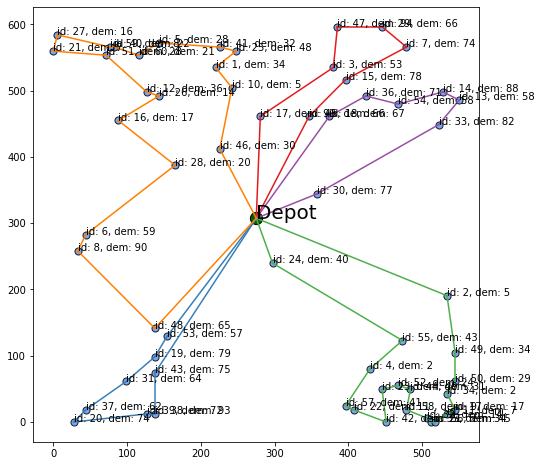

In [18]:
# CVRP
instance = generation.generate_instance(variant='cvrp', num_customers=60, dem_distr='quadrant', depot_pos='central', loc_distr='cavity_dispersion')
print(instance.gen_params,'\n')
instance.solve(first_solution='PATH_CHEAPEST_ARC',
               local_search='GUIDED_LOCAL_SEARCH', 
               time_limit=5, verbose=2)
instance.plot(solved=True, fig_size=(8,8), details='all', font_size=10)

#### CVRPTW

{'area': 169717.5291, 'side_ratio': 1.2973, 'lx': 361.6956, 'ly': 469.2275, 'num_customers': 66, 'depot_pos': 'central', 'loc_distr': 'uniform_triangular', 'dem_distr': 'lowval_highcv', 'cap_ratio': 0.1433, 'avg_route_size': 9.4578, 'possible_rounds': 4.2646, 'st_distr': 'proportional', 'tw_share': 0.6062, 'tw_center_distr': 'discrete', 'tw_width_distr': 'unitary'} 

Solution distance: 4773.61 (vehicles used: 8)

Route for vehicle 0 (distance=244.92, load=37, time=5526.44):
 0 (d0,l0,t0) -> 65 (d58,l9,t58) -> 1 (d100,l18,t306) -> 13 (d135,l26,t3543) -> 52 (d147,l31,t5315) -> 62 (d176,l37,t5458) -> 0 (d244,l37,t5526)

Route for vehicle 2 (distance=651.36, load=45, time=6338.44):
 0 (d0,l0,t0) -> 20 (d70,l6,t70) -> 6 (d142,l7,t279) -> 34 (d197,l16,t356) -> 8 (d212,l21,t885) -> 63 (d316,l23,t1771) -> 11 (d345,l28,t1845) -> 31 (d400,l37,t5315) -> 23 (d456,l39,t5577) -> 27 (d514,l45,t6201) -> 0 (d651,l45,t6338)

Route for vehicle 3 (distance=647.71, load=50, time=6397.67):
 0 (d0,l0,t0) -> 

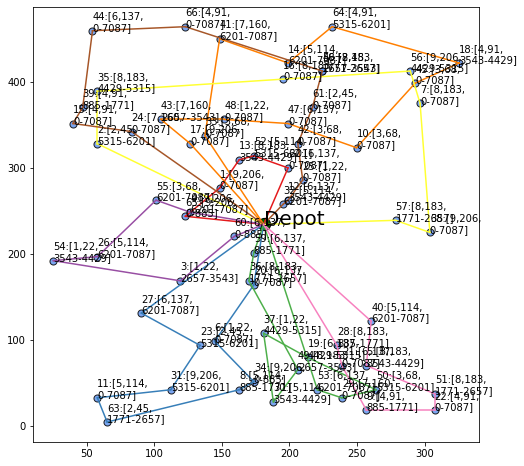

In [27]:
# CVRPTW
instance = generation.generate_instance(variant='cvrptw')
print(instance.gen_params,'\n')
instance.solve(first_solution='PATH_CHEAPEST_ARC',
               local_search='GUIDED_LOCAL_SEARCH', 
               time_limit=5, verbose=2)
instance.plot(solved=True, fig_size=(8,8), details='all', font_size=10)

Solution distance: 4317.24 (vehicles used: 8)

Route for vehicle 0 (distance=375.7, load=21, time=6329.8):
 0 (d0,l0,t0) -> 59 (d33,l6,t885) -> 36 (d66,l14,t1771) -> 3 (d117,l15,t2657) -> 54 (d214,l16,t3543) -> 26 (d247,l21,t6201) -> 0 (d375,l21,t6329)

Route for vehicle 1 (distance=605.0, load=49, time=6504.29):
 0 (d0,l0,t0) -> 12 (d33,l6,t3543) -> 25 (d59,l7,t3706) -> 10 (d114,l10,t3783) -> 7 (d183,l18,t3920) -> 45 (d207,l21,t4127) -> 18 (d247,l25,t4235) -> 56 (d285,l34,t4429) -> 64 (d362,l38,t5315) -> 14 (d415,l43,t6201) -> 47 (d486,l49,t6385) -> 0 (d605,l49,t6504)

Route for vehicle 2 (distance=634.61, load=46, time=6612.82):
 0 (d0,l0,t0) -> 65 (d58,l9,t58) -> 15 (d194,l13,t400) -> 39 (d215,l17,t885) -> 35 (d236,l25,t4429) -> 44 (d307,l31,t4682) -> 66 (d376,l35,t4888) -> 41 (d405,l42,t6201) -> 48 (d498,l43,t6455) -> 33 (d522,l46,t6500) -> 0 (d634,l46,t6612)

Route for vehicle 3 (distance=651.09, load=51, time=4759.0):
 0 (d0,l0,t0) -> 57 (d97,l8,t1771) -> 38 (d126,l17,t1983) -> 4

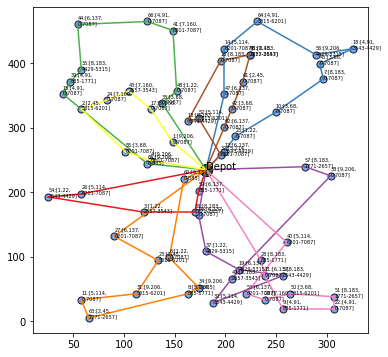

In [28]:
# longer time limit to find better route
instance.solve(first_solution='PATH_CHEAPEST_ARC',
               local_search='GUIDED_LOCAL_SEARCH', 
               time_limit=30, verbose=2)
instance.plot(solved=True, fig_size=(6,6), details='all')

### 3.2. Dataset generation <a name="dataset"></a>

#### Generate dataset

In [33]:
# # Generate dataset
# path = 'data/generated/'
# generation.generate_dataset(
#     path, 
#     num_instances=2, 
#     start_count=101, 
#     variant='cvrptw', 
#     verbose=True, 
#     solved=True)

Saved: cvrptw000101
Saved: cvrptw000102
